In [1]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import os
import torchvision
import sklearn.metrics as metrics
import numpy as np
import seaborn as sns
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import time
from utils_for_me import *
from torch.optim.lr_scheduler import CosineAnnealingLR
from model import Fully_Connected_AE


In [2]:
class opt:
    leave =1
    batch_size = 64
    dimensions = '512,256,64,16,0,0'
    input_dim= 784
    sigmoid = False
    pretrained_run = 'retraining'
    lr=0.001
    epoch = 10
    weights_to_prune = ['1','2','3','4','5','6','7','8']
    bias = True

In [3]:
mnist_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
#     torchvision.transforms.Normalize((0.5,), (1.0,))
])

ind_dataset = torchvision.datasets.MNIST('./dataset', transform=mnist_transform, train=False, download=True)
train_dataset = torchvision.datasets.MNIST('./dataset', transform=mnist_transform, train=True, download=True)

idx = train_dataset.targets!=opt.leave
train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                         batch_size=opt.batch_size,
                         shuffle=True)

idx = ind_dataset.targets!=opt.leave
ind_dataset.targets = ind_dataset.targets[idx]
ind_dataset.data = ind_dataset.data[idx]

ind_loader = torch.utils.data.DataLoader(dataset=ind_dataset, 
                         batch_size=opt.batch_size,
                         shuffle=False)

mnist_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
#     torchvision.transforms.Normalize((0.5,), (1.0,))
])

ood_dataset = torchvision.datasets.MNIST('./dataset', transform=mnist_transform, train=False, download=True)

idx = ood_dataset.targets==opt.leave
ood_dataset.targets = ood_dataset.targets[idx]
ood_dataset.data = ood_dataset.data[idx]

ood_loader = torch.utils.data.DataLoader(dataset=ood_dataset, 
                         batch_size=opt.batch_size,
                         shuffle=False)



In [4]:
dimensions = list(map(int,opt.dimensions.split(',')))
if len(dimensions)!=6:
    raise('give me 6 dimensions for autoencoder network!')

model_name = "_".join(opt.dimensions.split(','))


In [5]:

remaining_sparsity = 0.1
sparsity_levels={
    'encoder.fc1.weight':0,  #784*512,
    'encoder.fc2.weight':remaining_sparsity, #512*256,
    'encoder.fc3.weight':remaining_sparsity,#256*64
    'encoder.fc4.weight':remaining_sparsity , # 64*16
    'decoder.fc4.weight':0, #16*64 ,
    'decoder.fc3.weight':64*256 - 5,#64*256
    'decoder.fc2.weight':0,#256*512
    'decoder.fc1.weight':0,
}

In [6]:
pruned_model = Fully_Connected_AE(opt.input_dim, dimensions,opt.sigmoid, opt.bias)

ckpt_name = '{}_sigmoid_{}_epoch_{}_run_{}'.format(model_name,opt.sigmoid,'100', opt.pretrained_run)
ckpt_path = os.path.join('trained_models','pretrained','leave_out_{}'.format(opt.leave), ckpt_name + ".pth")
print(ckpt_path)
pruned_model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))


pruned_model = pruned_model.cuda()



trained_models/pretrained/leave_out_1/512_256_64_16_0_0_sigmoid_False_epoch_100_run_retraining.pth


In [7]:
ind_recon = reconstrucion_errors(pruned_model, ind_loader)
ood_recon = reconstrucion_errors(pruned_model, ood_loader)
        
auroc = calculate_auroc(ind_recon, ood_recon)
print('auroc = {}'.format(auroc))
print('ind_recon_mean = {}'.format(torch.mean(ind_recon)))
print('ood_recon_mean = {}'.format(torch.mean(ood_recon)))


auroc = 0.3141695674967886
ind_recon_mean = 3.0057058334350586
ood_recon_mean = 2.6190078258514404


/home/dyros/anaconda3/envs/yhpark/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


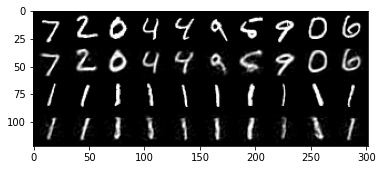

In [8]:
img_grid = check_reconstructed_images(pruned_model, None, 0, 0, "after_FT", ind_loader, ood_loader, None, model_name, opt.sigmoid, None, False)
plt.imshow(img_grid.cpu().numpy().transpose(1,2,0))

In [9]:
all_layers = [(pruned_model.encoder.fc1,'weight'),(pruned_model.encoder.fc2,'weight'),(pruned_model.encoder.fc3,'weight'),(pruned_model.encoder.fc4,'weight'),(pruned_model.decoder.fc4,'weight'),(pruned_model.decoder.fc3,'weight'),(pruned_model.decoder.fc2,'weight'),(pruned_model.decoder.fc1,'weight')] 

parameters_to_prune = []

print(opt.weights_to_prune)

for i0 in opt.weights_to_prune:

    parameters_to_prune.append(all_layers[int(i0)-1])

parameters_to_prune = tuple(parameters_to_prune)

trained_weight = pruned_model.state_dict()

for pruning_weight_num in opt.weights_to_prune:
    if int(pruning_weight_num) <5 : 
        name = 'encoder.fc{}.weight'.format(pruning_weight_num)
    else:
        name = 'decoder.fc{}.weight'.format(9-int(pruning_weight_num))
    scores = abs(trained_weight[name]) # torch.rand_like(trained_weight[name])# 
    prune.l1_unstructured(all_layers[int(pruning_weight_num)-1][0], 'weight', sparsity_levels[name],scores)


['1', '2', '3', '4', '5', '6', '7', '8']


In [10]:
ind_recon = reconstrucion_errors(pruned_model, ind_loader)
ood_recon = reconstrucion_errors(pruned_model, ood_loader)
        
auroc = calculate_auroc(ind_recon, ood_recon)
print('auroc = {}'.format(auroc))
print('ind_recon_mean = {}'.format(torch.mean(ind_recon)))
print('ood_recon_mean = {}'.format(torch.mean(ood_recon)))


auroc = 0.10731491213031498
ind_recon_mean = 9.123926162719727
ood_recon_mean = 6.833196640014648


/home/dyros/anaconda3/envs/yhpark/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


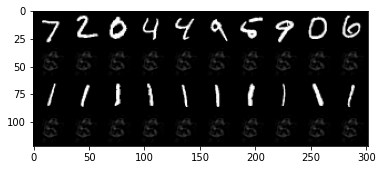

In [11]:
img_grid = check_reconstructed_images(pruned_model, None, 0, 0, "after_FT", ind_loader, ood_loader, None, model_name, opt.sigmoid, None, False)
plt.imshow(img_grid.cpu().numpy().transpose(1,2,0))

In [12]:
for this_layer in range(8):
    layer_sparsity = show_layer_sparsity(pruned_model, this_layer)
    # print(layer_sparsity)

Sparsity of layer 0 : 0.0000000000%
Sparsity of layer 1 : 9.9998474121%
Sparsity of layer 2 : 9.9975585938%
Sparsity of layer 3 : 9.9609375000%
Sparsity of layer 4 : 0.0000000000%
Sparsity of layer 5 : 99.9755859375%
Sparsity of layer 6 : 0.0000000000%
Sparsity of layer 7 : 0.0000000000%


In [13]:
optimizer = torch.optim.Adam(pruned_model.parameters(), opt.lr)

# time.sleep(5)
pruned_model.train()

loss_list = []
total_step=0
for epoch in trange(1, 20+ 1):
    avg_loss = 0
    step = 0
    for (data,label) in train_loader:
        step += 1
        total_step+=1
        data = data.reshape(-1,784).cuda()
        optimizer.zero_grad()
        recon_error = pruned_model.recon_error(data)
        loss = torch.mean(recon_error)
        loss.backward()
        optimizer.step()
        avg_loss += loss
        loss_list.append(avg_loss/step)


100%|██████████| 20/20 [02:06<00:00,  6.33s/it]


In [14]:
ind_recon = reconstrucion_errors(pruned_model, ind_loader)
ood_recon = reconstrucion_errors(pruned_model, ood_loader)
        
auroc = calculate_auroc(ind_recon, ood_recon)
print('auroc = {}'.format(auroc))
print('ind_recon_mean = {}'.format(torch.mean(ind_recon)))
print('ood_recon_mean = {}'.format(torch.mean(ood_recon)))


auroc = 0.38098814572975437
ind_recon_mean = 5.036654472351074
ood_recon_mean = 4.676232814788818


/home/dyros/anaconda3/envs/yhpark/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


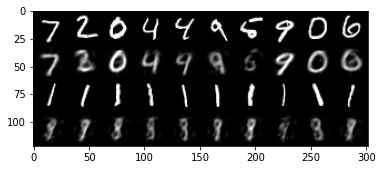

In [15]:
img_grid = check_reconstructed_images(pruned_model, None, 0, 0, "after_FT", ind_loader, ood_loader, None, model_name, opt.sigmoid, None, False)
plt.imshow(img_grid.cpu().numpy().transpose(1,2,0))